In [1]:
import os
import json
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from torchvision import models, datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [2]:
from torch.utils.data._utils.collate import default_collate

def collate_fn(batch):
    """
    Custom collation function for handling variable-sized target tensors.
    Each item in the batch is a dictionary with keys 'image', 'boxes', 'labels'.
    """
    # Extract images and targets from the batch
    images = [item['image'] for item in batch]
    targets = [{'boxes': item['boxes'], 'labels': item['labels']} for item in batch]

    # Use the default_collate to collate images
    images = default_collate(images)

    return images, targets

In [3]:
class ObjectDataset(Dataset):
    def __init__(self, csv_file, img_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Use the custom parser to read the CSV
        self.flags_frame = pd.read_csv(csv_file)
        
        self.img_dir = img_dir


    def __len__(self):
        return len(self.flags_frame)

    def __getitem__(self, idx):
        # Find all rows corresponding to the same image
        img_file_name = self.flags_frame.iloc[idx, 0]
        img_rows = self.flags_frame[self.flags_frame['filename'] == img_file_name]

        # Initialize lists for boxes and labels
        boxes = []
        labels = []

        # Load image
        img_name = os.path.join(self.img_dir, img_file_name)
        image = Image.open(img_name)

        # Iterate over all rows for this image
        for _, row in img_rows.iterrows():
            x, y, width, height = row['x'], row['y'], row['width'], row['height']
            box = self.parse_box_data(x, y, width, height)
            boxes.append(box)

            label_data = row['object_type']
            label = self.parse_label_data(label_data)
            labels.append(label)

        sample = {'image': image, 'boxes': boxes, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

    @staticmethod
    def parse_box_data(x,y, width, height):
        # The box_data string needs to be cleaned up to be a valid JSON
        # Convert double double quotes to single double quotes
            
            
        # Convert to [xmin, ymin, xmax, ymax] format
        xmin = x
        ymin = y
        xmax = x + width
        ymax = y + height

        return [xmin, ymin, xmax, ymax]

    @staticmethod
    def parse_label_data(label_data):

        # Extract the object type
        object_type = label_data

        # Convert object types to numerical labels
        label_dict = {'flag': 1, 'map': 2}  # Define your label mapping here
        label = label_dict.get(object_type, 0)  # Default label 0 for unknown types

        return label

    @staticmethod
    def transform(sample):
        image, boxes, labels = sample['image'], sample['boxes'], sample['labels']
        original_size = image.size  # Original size of the image (W, H)
        
        # Resize image
        new_size = (448, 448)
        image = image.convert('RGB')
        image = F.resize(image, new_size)

        # Convert image to tensor
        image = F.to_tensor(image)

        # Adjust bounding boxes
        boxes = ObjectDataset.adjust_boxes(boxes, original_size, new_size)

        return {'image': image, 'boxes': torch.as_tensor(boxes, dtype=torch.float32), 'labels': torch.as_tensor(labels, dtype=torch.int64)}


    @staticmethod
    def adjust_boxes(boxes, original_size, new_size):
        #print(boxes)
        # Adjust the bounding box coordinates based on the new image size
        x_scale = new_size[0] / original_size[0]
        y_scale = new_size[1] / original_size[1]

        adjusted_boxes = []
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            xmin = xmin * x_scale
            xmax = xmax * x_scale
            ymin = ymin * y_scale
            ymax = ymax * y_scale
            adjusted_boxes.append([xmin, ymin, xmax, ymax])

        return adjusted_boxes


In [4]:
# Initialize the dataset
object_dataset = ObjectDataset(csv_file='/home/guslasbo@GU.GU.SE/MIDA/Dataset/Labelling/flags_complete.csv',
                               img_dir='/home/guslasbo@GU.GU.SE/MIDA/Dataset/Images')

In [5]:
total_size = len(object_dataset)
train_size = int(0.8 * total_size)
test_size = val_size = int(0.1 * total_size)
# Adjust the train size to account for rounding
train_size += total_size - (train_size + test_size + val_size)

# Ensure your random splits add up to the total size
assert train_size + test_size + val_size == total_size

In [6]:
train_dataset, val_dataset, test_dataset = random_split(object_dataset, [train_size, val_size, test_size])

In [7]:
batch_size = 8  # You can adjust the batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

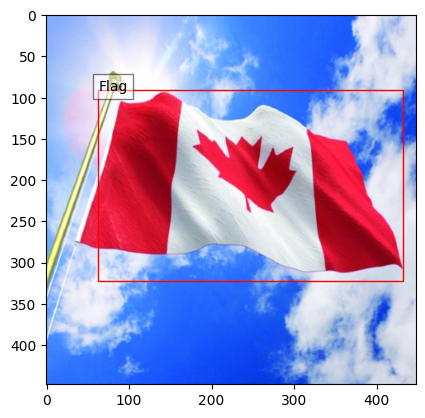

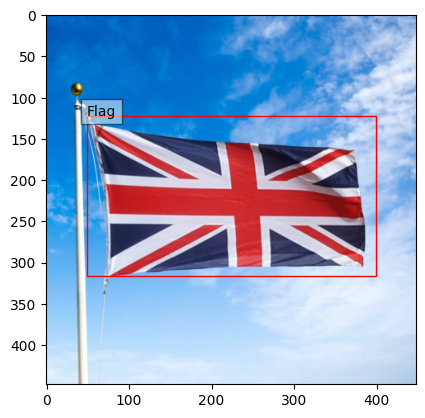

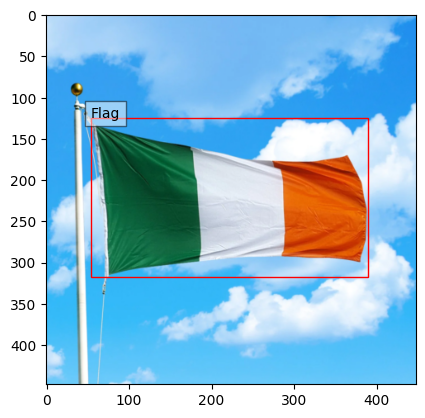

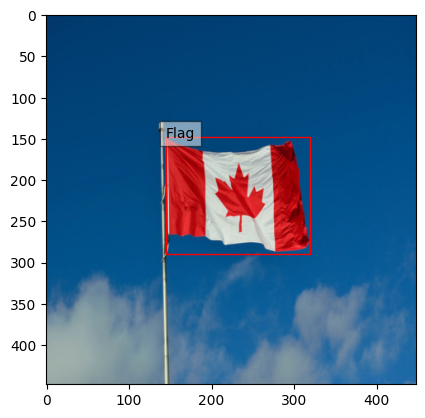

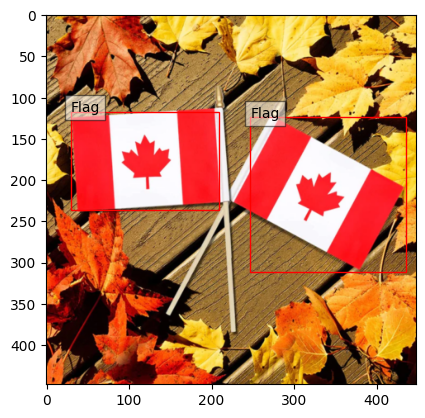

In [8]:
def show_image_with_boxes(dataset, idx, label_map=None):
    sample = dataset[idx]
    image, boxes, labels = sample['image'], sample['boxes'], sample['labels']

    if not isinstance(image, torch.Tensor):
        image = F.to_tensor(image)
    np_image = image.cpu().numpy().transpose(1, 2, 0)
    np_image = np_image - np_image.min()
    np_image = np_image / np_image.max()

    fig, ax = plt.subplots(1)
    ax.imshow(np_image)



    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label_value = label.item()
        label_text = f'{label_value}' if label_map is None else label_map.get(label_value, 'Unknown')
        ax.text(xmin, ymin, label_text, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Label map
label_map = {1: 'Flag', 2: 'Map'}

# Preview first few images in the dataset
for i in range(5):
    show_image_with_boxes(object_dataset, i, label_map)

In [9]:
# Object Detection Model
object_detection_model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
object_detection_model.to(device)
# Freeze certain layers for fine-tuning
for layer in object_detection_model.parameters():
    layer.requires_grad = False

# Modify the model for the new number of classes (2 + background)
in_features = object_detection_model.roi_heads.box_predictor.cls_score.in_features
object_detection_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

'''
# Image Classification Model
image_classification_model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers except the last one
for param in image_classification_model.parameters():
    param.requires_grad = False
image_classification_model.fc.requires_grad = True

# Replace the pre-trained head with a new one
num_classes = 20  # Placeholder because I forgot how many we were going to use
image_classification_model.fc = nn.Linear(image_classification_model.fc.in_features, num_classes)
'''


'\n# Image Classification Model\nimage_classification_model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)\n\n# Freeze all layers except the last one\nfor param in image_classification_model.parameters():\n    param.requires_grad = False\nimage_classification_model.fc.requires_grad = True\n\n# Replace the pre-trained head with a new one\nnum_classes = 20  # Placeholder because I forgot how many we were going to use\nimage_classification_model.fc = nn.Linear(image_classification_model.fc.in_features, num_classes)\n'

In [10]:


# Assuming train_loader and val_loader are properly set up
params = [p for p in object_detection_model.parameters() if p.requires_grad]
object_detection_model = object_detection_model.to(device)
#print("Model device:", next(object_detection_model.parameters()).device)
#print("Box predictor device:", next(object_detection_model.roi_heads.box_predictor.parameters()).device)

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10
best_val_loss = float('inf')


for epoch in range(num_epochs):
    object_detection_model.train()
    train_loss = 0.0

    # Wrap train_loader with tqdm for a progress bar
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for images, targets in progress_bar:
        
        images = list(img.to(device) for img in images)
        #print("Images device:", images[0].device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Check device for each target tensor
        '''
        for target in targets:
            for key, value in target.items():
                if isinstance(value, torch.Tensor):
                    print(f"Target tensor '{key}' device:", value.device)
        '''

        optimizer.zero_grad()
        loss_dict = object_detection_model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        # Update progress bar with current loss
        progress_bar.set_postfix({'train_loss': losses.item()})

    # Validation phase
    object_detection_model.eval()  # Ensure the model is in eval mode for correct behavior
    val_loss = 0.0
    progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
    with torch.no_grad():
        for images, targets in progress_bar:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Temporarily set the model to training mode to compute the loss
            object_detection_model.train()
            loss_dict = object_detection_model(images, targets)
            object_detection_model.eval()  # Set it back to eval mode

            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            # Update progress bar with current validation loss
            progress_bar.set_postfix({'val_loss': losses.item()})

    # Learning rate scheduler step
    scheduler.step()

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(object_detection_model.state_dict(), 'best_object_detection_model.pth')

    print(f'Epoch {epoch}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')


Epoch 1/10 [Validation]: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it, val_loss=0.328]


Epoch 0, Train Loss: 0.5021568399763876, Val Loss: 0.37722666561603546


Epoch 2/10 [Validation]: 100%|██████████| 8/8 [00:10<00:00,  1.30s/it, val_loss=0.281]


Epoch 1, Train Loss: 0.33613411216966566, Val Loss: 0.3429334405809641


Epoch 3/10 [Validation]: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it, val_loss=0.287]


Epoch 2, Train Loss: 0.3214431974676348, Val Loss: 0.3387496881186962


Epoch 4/10 [Validation]: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it, val_loss=0.265]


Epoch 3, Train Loss: 0.323184858647085, Val Loss: 0.3312673233449459


Epoch 5/10 [Validation]: 100%|██████████| 8/8 [00:10<00:00,  1.30s/it, val_loss=0.26] 


Epoch 4, Train Loss: 0.309512430501561, Val Loss: 0.3305728081613779


Epoch 6/10 [Validation]: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it, val_loss=0.256]


Epoch 5, Train Loss: 0.309028881091264, Val Loss: 0.3266967963427305


Epoch 7/10 [Validation]: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it, val_loss=0.27] 


Epoch 6, Train Loss: 0.3080370337251694, Val Loss: 0.33105758763849735


Epoch 8/10 [Validation]: 100%|██████████| 8/8 [00:10<00:00,  1.32s/it, val_loss=0.269]


Epoch 7, Train Loss: 0.3090757501702155, Val Loss: 0.3300304412841797


Epoch 9/10 [Validation]: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it, val_loss=0.257]


Epoch 8, Train Loss: 0.3184776725547929, Val Loss: 0.3292040005326271


Epoch 10/10 [Validation]: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it, val_loss=0.264]

Epoch 9, Train Loss: 0.3085341734751578, Val Loss: 0.33107905462384224


In [11]:
optimizer = torch.optim.SGD(image_classification_model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    image_classification_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = image_classification_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    image_classification_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = image_classification_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Learning rate scheduler step
    scheduler.step()

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(image_classification_model.state_dict(), 'best_image_classification_model.pth')

    print(f'Epoch {epoch}, Train Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')


NameError: name 'image_classification_model' is not defined

In [ ]:
# Load fine-tuned object detection model
object_detection_model.load_state_dict(torch.load('best_object_detection_model.pth'))
object_detection_model.to(device)
object_detection_model.eval()

# Load fine-tuned image classification model
image_classification_model.load_state_dict(torch.load('best_image_classification_model.pth'))
image_classification_model.to(device)
image_classification_model.eval()

# Define the transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #  Resize code, as I will resize the data to this in the data class
    transforms.ToTensor(),
    # Maybe going to add normalization (only if I end up using it for training)
])

# Load the image and apply transforms
image_path = "flag.jpg"  # Path image should be here
image = Image.open(image_path)
image = transform(image).unsqueeze(0)
image = image.to(device)

# Detect objects in the image
object_detection_results = object_detection_model([image])


In [ ]:
# Extract flag and map image patches
for detection in object_detection_results[0]['boxes']:
    labels = object_detection_results[0]['labels']
    scores = object_detection_results[0]['scores']

    for i, box in enumerate(detection):
        if scores[i] > 0.5:  # Threshold to filter out low-confidence detections
            if labels[i] == 1:  # placeholder position for flag
                flag_image_patch = image[:, int(box[1]):int(box[3]), int(box[0]):int(box[2])].unsqueeze(0)
                flag_image_patches.append(flag_image_patch)
            elif labels[i] == 2:  # placeholder position for map
                map_image_patch = image[:, int(box[1]):int(box[3]), int(box[0]):int(box[2])].unsqueeze(0)
                map_image_patches.append(map_image_patch)


In [ ]:
# Classify each flag image patch
flag_labels = []
for flag_image_patch in flag_image_patches:
    flag_image_patch = flag_image_patch.to(device)
    flag_predictions = image_classification_model(flag_image_patch)
    flag_prediction = torch.argmax(flag_predictions, dim=1).item()
    flag_labels.append(flag_prediction)

# Similar loop for map image patches
map_labels = []
for map_image_patch in map_image_patches:
    map_image_patch = map_image_patch.to(device)
    map_predictions = image_classification_model(map_image_patch)
    map_prediction = torch.argmax(map_predictions, dim=1).item()
    map_labels.append(map_prediction)
